# Colab env settings

In [1]:
!git clone https://github.com/bochendong/car_racing.git

fatal: destination path 'car_racing' already exists and is not an empty directory.


In [2]:
%%capture
!sudo apt update && sudo apt install python-opengl
!sudo apt update && sudo apt install xvfb
!pip install gym-notebook-wrapper stable-baselines[mpi] box2d box2d-kengz pyvirtualdisplay pyglet
!pip install wandb
!pip install pyvirtualdisplay -qq
!pip install folium==0.2.1
!apt-get install -y xvfb python-opengl ffmpeg -qq

In [3]:
import numpy as np

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

from torch.autograd import Function

import gnwrapper
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(30)

from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import wandb

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [4]:
!pip install box2d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [6]:
%cd car_racing

/content/car_racing


In [7]:
import car_racing as cr
import replay_memory as rm

# Carracing Enviorment settings

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
env_green = gnwrapper.Animation(cr.CarRacing())
env_green = cr.CarRacing(color = 'g')
obs = env_green.reset()
print(obs.shape)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


retry to generate track (normal if there are not manyinstances of this message)
(96, 96, 3)


In [10]:
env_red= gnwrapper.Animation(cr.CarRacing(color = 'r'))
env_red = cr.CarRacing(color = 'r')
obs = env_red.reset()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [11]:
env_blue = gnwrapper.Animation(cr.CarRacing(color = 'b'))
env_blue = cr.CarRacing(color = 'b')
obs = env_blue.reset()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [12]:
print(obs.shape)

(96, 96, 3)


In [13]:
obs_array = []
discrete_actions = {0 : np.array([0,0,0]),       # do nothing
                                 1 : np.array([-1,0,0]),      # steer sharp left
                                 2 : np.array([1,0,0]),       # steer sharp right
                                 3 : np.array([-0.5,0,0]),    # steer left
                                 4 : np.array([0.5,0,0]),     # steer right
                                 5 : np.array([0,1,0]),       # accelerate 100%
                                 6 : np.array([0,0.5,0]),     # accelerate 50%
                                 7 : np.array([0,0.25,0]),    # accelerate 25%
                                 8 : np.array([0,0,1]),       # brake 100%
                                 9 : np.array([0,0,0.5]),     # brake 50%
                                 10 : np.array([0,0,0.25])}   # brake 25%

def get_obs(env):
    obs_array = []
    n_actions = len(discrete_actions)
    for i in range (0, 40):
        action = torch.randint(low=0, high=11, size=(1,))
        action_transfered = discrete_actions.get(int(action[0]))

        obs, reward, done, _ = env.step([action_transfered[0], action_transfered[1], action_transfered[2]])
        if (i % 4 == 0):
            obs_array.append(obs)

    return obs_array

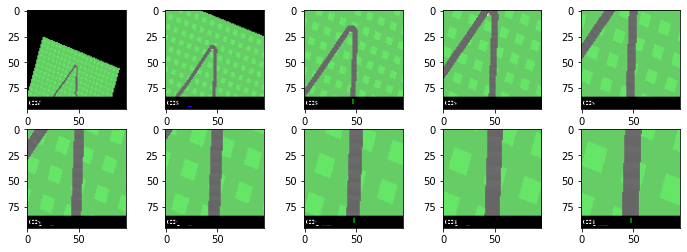

In [14]:
f, axs = plt.subplots(2,5, figsize = (12, 4))

axs = axs.flatten()
obs_array = get_obs(env_green)
for img, ax in zip(obs_array, axs):
    ax.imshow(img)
plt.show()

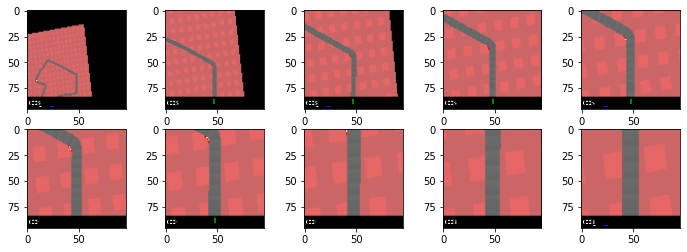

In [15]:
f, axs = plt.subplots(2,5, figsize = (12, 4))

axs = axs.flatten()
obs_array = get_obs(env_red)
for img, ax in zip(obs_array, axs):
    ax.imshow(img)
plt.show()

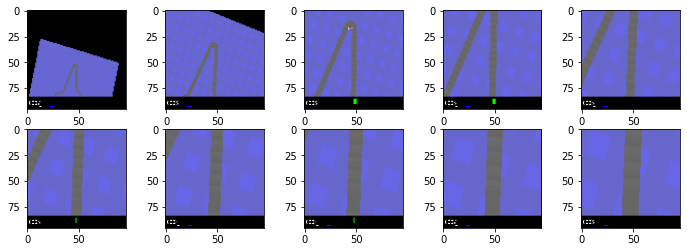

In [16]:
f, axs = plt.subplots(2,5, figsize = (12, 4))

axs = axs.flatten()
obs_array = get_obs(env_blue)
for img, ax in zip(obs_array, axs):
    ax.imshow(img)
plt.show()

# PPO Models

In [17]:
class Env():
    def __init__(self, color, seed = 0):
        self.env = gnwrapper.Animation(cr.CarRacing(color = color))
        self.env = cr.CarRacing(color = color)
        self.color = color
        self.env.seed(seed)
        self.reward_threshold = 1000

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb = self.env.reset()
        img_rgb = img_rgb / 128. - 1
        self.stack = [img_rgb] * 4
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(8):
            img_rgb, reward, die, _ = self.env.step(action)

            if die: reward += 100

            if self.color == 'g' and np.mean(img_rgb[:, :, 1]) > 185.0:
                  reward -= 0.05

            total_reward += reward

            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break

        img_rgb = img_rgb / 128. - 1
        self.stack.pop(0)
        self.stack.append(img_rgb)
        assert len(self.stack) == 4
        return np.array(self.stack), total_reward, done, die

    def step_eval(self, action):
        img_rgb, reward, done, _ = self.env.step(action)

        img_rgb = img_rgb / 128. - 1
        self.stack.pop(0)
        self.stack.append(img_rgb)
        return np.array(self.stack), reward, done, _

    def render(self, *arg):
        self.env.render(*arg)

    @staticmethod
    def reward_memory():
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

In [18]:
env_green = Env(color = 'g', seed = 0)
obs_green = env_green.reset()

env_red = Env(color = 'r', seed = 0)
obs_red = env_red.reset()

env_blue = Env(color = 'b', seed = 0)
obs_blue = env_blue.reset()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [19]:
class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None  

class DANN(nn.Module):
    def __init__(self):
        super(DANN, self).__init__()
        self.sketch = nn.Sequential(
            nn.Conv3d(4, 4, kernel_size=(1, 1, 3), stride=1),
            nn.ReLU(),
        )
        self.feature = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(4, 8, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),
        )

        self.cnn_base = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(64 * 5 * 5, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(True),
            nn.Linear(1000, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
        )

        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)
      
    def forward(self, input, a = 0.1):
        sketch = self.sketch(input)
        sketch = torch.squeeze(sketch)

        feature = self.feature(sketch)

        out = self.cnn_base(feature)
        out = out.view(-1, 256)
        v = self.v(out)
        out = self.fc(out)

        alpha = self.alpha_head(out) + 1
        beta = self.beta_head(out) + 1

        feature = feature.view(-1, 64 * 5 * 5)
        reverse_feature = ReverseLayerF.apply(feature, a)
        domain_output = self.domain_classifier(reverse_feature)

        return (alpha, beta), v, domain_output

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

In [20]:
transition = np.dtype([('s', np.float64, (4, 96, 96, 3)), ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (4, 96, 96, 3))])

In [21]:
class Agent():
    max_grad_norm = 0.5
    clip_param = 0.1
    ppo_epoch = 10
    buffer_capacity, batch_size = 2000, 128

    def __init__(self):
        self.training_step = 0
        self.net = DANN().double().to(device)
        self.buffer = np.empty(self.buffer_capacity, dtype=transition)
        self.target_buffer = np.empty(self.buffer_capacity, dtype=transition)
        self.source_counter = 0
        self.target_counter = 0
        self.criterion = nn.CrossEntropyLoss().to(device)

        self.optimizer = optim.Adam(self.net.parameters(), lr=1e-3)

    def select_action(self, state):
        state = torch.from_numpy(state).double().to(device).unsqueeze(0)
        with torch.no_grad():
            out = self.net.sketch(state)
            out = torch.squeeze(out)
            out = self.net.feature(out)

            out = self.net.cnn_base(out)
            out = out.view(-1, 256)
            out = self.net.fc(out)
            alpha = self.net.alpha_head(out) + 1
            beta = self.net.beta_head(out) + 1

        dist = Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).sum(dim=1)

        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        return action, a_logp

    def save_param(self):
        torch.save(self.net.state_dict(), 'param/ppo_net_params.pkl')

    def store(self, transition, which_env = 'source'):
        if (which_env == 'source'):
            self.buffer[self.source_counter] = transition
            self.source_counter += 1
            if self.source_counter == self.buffer_capacity:
                self.source_counter = 0
                return True
        else:
            self.target_buffer[self.target_counter] = transition
            self.target_counter += 1
            if self.target_counter == self.buffer_capacity:
                self.target_counter = 0
                return True

        return False

    def update(self):
        self.training_step += 1

        s = torch.tensor(self.buffer['s'], dtype=torch.double).to(device)
        a = torch.tensor(self.buffer['a'], dtype=torch.double).to(device)
        r = torch.tensor(self.buffer['r'], dtype=torch.double).to(device).view(-1, 1)
        s_ = torch.tensor(self.buffer['s_'], dtype=torch.double).to(device)
        old_a_logp = torch.tensor(self.buffer['a_logp'], dtype=torch.double).to(device).view(-1, 1)


        s_t =  torch.tensor(self.target_buffer['s'], dtype=torch.double).to(device)

        with torch.no_grad():
            target_v = r + 0.99 * self.net(s_)[1]
            adv = target_v - self.net(s)[1]

        for _ in range(self.ppo_epoch):
            correct_source_domain = 0
            correct_target_domain = 0
            total = 0
            for index in BatchSampler(SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):
                (alpha, beta), v, source_domain_out = self.net(s[index])
                _, _, target_domain_out = self.net(s_t[index])

                batch_size = source_domain_out.size()[0]
                total += batch_size

                dist = Beta(alpha, beta)
                a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True)
                ratio = torch.exp(a_logp - old_a_logp[index])
                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.smooth_l1_loss(self.net(s[index])[1], target_v[index])

                domain_label = torch.zeros(batch_size).long()
                domain_label = domain_label.to(device)
                source_domain_loss = self.criterion(source_domain_out, domain_label)
                _, predicted = torch.max(source_domain_out.data, 1)
                correct_source_domain += predicted.eq(domain_label.data).cpu().sum().item()

                domain_label = torch.ones(batch_size).long()
                domain_label = domain_label.to(device)
                target_domain_loss = self.criterion(target_domain_out, domain_label)
                _, predicted = torch.max(target_domain_out.data, 1)
                correct_target_domain += predicted.eq(domain_label.data).cpu().sum().item()

                loss = action_loss + 2. * value_loss + source_domain_loss + target_domain_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()


# Training

In [22]:
agent = Agent()
env_green = Env(color = 'g', seed = 0)
env_red = Env(color = 'r', seed = 0)
env_blue = Env(color = 'b', seed = 0)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
training_records = []
source_running_score = 0
target_running_score = 0
for i_ep in range(3000):
    source_score = 0
    target_score = 0
    source_state = env_green.reset()
    target_state = env_red.reset()

    for t in range(1000):
        source_action, source_a_logp = agent.select_action(source_state)
        target_action, target_a_logp = agent.select_action(target_state)

        source_state_, source_reward, source_done, source_die = env_green.step(source_action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))
        target_state_, target_reward, target_done, target_die = env_red.step(target_action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

        should_update = agent.store((source_state, source_action, source_a_logp, source_reward, source_state_), which_env = 'source')
        agent.store((target_state, target_action, target_a_logp, target_reward, target_state_), which_env = 'target')

        if should_update: agent.update()

        source_score += source_reward
        target_score += target_reward

        source_state = source_state_
        target_state = target_state_
        if source_done or source_die or target_done or target_die:
            break
    source_running_score = source_running_score * 0.99 + source_score * 0.01
    target_running_score = target_running_score * 0.99 + target_score * 0.01

    if i_ep % 100 == 0:
        print('Source: Ep {}\tLast score: {:.2f}\tMoving average score: {:.2f}'.format(i_ep, source_score, source_running_score))
        print('Target: Ep {}\tLast score: {:.2f}\tMoving average score: {:.2f}'.format(i_ep, target_score, target_running_score))
    if source_running_score > env_green.reward_threshold:
        print("Solved! Running reward is now {} and the last episode runs to {}!".format(source_running_score, source_score))
        print("Solved! Running reward is now {} and the last episode runs to {}!".format(target_running_score, target_score))
        break

/usr/local/lib/python3.7/dist-packages/torch/distributions/dirichlet.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /root/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  torch.lgamma(self.concentration.sum(-1)) -


Source: Ep 0	Last score: -30.92	Moving average score: -0.31
Target: Ep 0	Last score: -7.53	Moving average score: -0.08
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)
r

# Eval

In [ ]:
def eval(agent, env):
    score = 0
    state = env.reset()

    for t in range(1000):
        action, a_logp = agent.select_action(state)

        state_, reward, done, _ = env.step_eval(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

        score += reward

        state = state_

        if done:
            break

    return score

In [ ]:
green_score = eval(agent, env_green)

In [ ]:
print(green_score)

In [ ]:
red_score = eval(agent, env_red)

In [ ]:
print(red_score)

In [ ]:
blue_score = eval(agent, env_blue)

In [ ]:
print(blue_score)